In [40]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy import stats
import mandelbrot

#### Define subarea class

In [21]:
class subarea:
    
    def __init__(self, par_a, par_i, prob):
        
        # Create a mandelbrot object for this area
        self.mandel = mandelbrot.mandel(par_a)
        
        # Edges of the subarea
        self.x_min = par_a[0]
        self.x_max = par_a[1]
        self.y_min = par_a[2]
        self.y_max = par_a[3]
        
        # Sampling probability
        self.probability = prob
        self.iterations = par_i
        
        # Variable that indicates if the probability should be increased
        self.prob_incr = False
    
    def subdivide(self, n_subareas):
        
        # Set the initial coordinates at the minimal value
        x_min = self.x_min
        x_max = self.x_min
        y_min = self.y_min
        y_max = self.y_min
        
        # List to store the newly created subareas
        new_subareas = []
        # Equally distribute the sampling probability over the subareas
        new_prob = self.probability / n_subareas
        
        # Calculate the length of the subareas
        distance_x = (self.x_max - self.x_min) / np.sqrt(n_subareas)
        distance_y = (self.y_max - self.y_min) / np.sqrt(n_subareas)
        
        # Determine the edges of the subareas
        for _ in range(int(np.sqrt(n_subareas))):
            # The minimal value is the maximal value of the previous subarea
            x_min = x_max
            x_max += distance_x
            
            for _ in range(int(np.sqrt(n_subareas))):
                y_min = y_max
                y_max += distance_y
                
                # Create subarea
                new_subareas.append(subarea([x_min, x_max, y_min, y_max], self.iterations, new_prob))
            
            y_min = self.y_min
            y_max = self.y_min
        
        return new_subareas

#### Creating subareas 
The following two cells create 100 area estimations using strategic sampling
At the Bottom there is also an estimation for clock time used in performing the experiment 100 times

In [36]:
area = [-2, 2, -2, 2]
start_iter = 400
start_samples =256
repeats = 10
cycles = 5
starting_subdivisions = 16
subdivisions = 4
np.random.seed(1337)

In [37]:

col_samplepoints = np.zeros((repeats))
col_est_areas_ss = np.zeros((repeats,cycles))

st = time.time()
for j in range(repeats):
    subspaces = subarea(area, start_iter, 1)
    subspaces = subspaces.subdivide(starting_subdivisions)
    samplepoints_ss = []
    est_areas = []
    previous_cumm_samples = 0
    # Improve sampling locations 5 times
    for n in range(cycles):

        prob_decr = 0           # Total probability decrease over all the subareas
        n_areas_incr = 0        # Number of subareas for which the probability should increase
        total_mandel_area = 0
        points = np.empty(0)
        loc_samples = start_samples* (2**n)
        
        
        for subspace in subspaces:

            # Determine number of samples in subarea
            n_samples = max(int(subspace.probability * loc_samples), 1)
            # Calculate the mandelbrot area in the subarea
            mandel_area, samples = subspace.mandel.est_area(n_samples, subspace.iterations, method = 'latin_hypercube')
            total_mandel_area += mandel_area

            # Store the samplepoints
            if len(points) == 0:
                points = samples
            else:
                points = np.concatenate((points, samples))


            if mandel_area == 0:
                # Areas outside of the Mandelbrot set
                subspace.iterations = start_iter 
                subspace.probability /= 2
                prob_decr += subspace.probability

            elif mandel_area == subspace.mandel.area:
                # Areas inside of the Mandelbrot set
                subspace.probability /= 2
                prob_decr += subspace.probability

            else:
                # Areas on the edge of the Mandelbrot set
                subspace.iterations = start_iter * (n + 1) 
                subspace.prob_incr = True
                n_areas_incr += 1
        # Increase the probability of the important areas
        add_prob = prob_decr / n_areas_incr
        new_subspaces = []

        for subspace in subspaces:
            if subspace.prob_incr == True:
                subspace.probability += add_prob
                subspace.prob_incr = False

            # Subdivide the areas every other iteration
            if n % 2 == 0:
                new_subareas = subspace.subdivide(subdivisions)
                new_subspaces += new_subareas

        if n % 2 == 0:
            subspaces = new_subspaces

        # Store the all the sampling points in this iteration
        samplepoints_ss.append(points)
        # Store the estimated area
        if previous_cumm_samples == 0:
            est_areas.append(total_mandel_area)
            previous_cumm_samples = loc_samples
        else:
            all_used_samples = previous_cumm_samples + loc_samples
            new_area = est_areas[-1]*(previous_cumm_samples/all_used_samples) + total_mandel_area*(loc_samples/all_used_samples)
            est_areas.append(new_area)
            previous_cumm_samples = all_used_samples
    
    
    col_est_areas_ss[j] = est_areas
        
print(time.time()-st,"seconds")

161.67212581634521 seconds


In [39]:
np.cumsum([256,512,1024,2048,4096,8192,16384])

array([  256,   768,  1792,  3840,  7936, 16128, 32512], dtype=int32)

The following two cells create 100 area estimations using basic Monte Carlo Method
At the Bottom there is also an estimation for clock time used in performing the experiment 100 times

In [30]:
area = [-2, 2, -2, 2]
start_iter = 400
start_samples =256

repeats = 10
cycles = 5
starting_subdivisions = 1
subdivisions = 1
np.random.seed(1337)

sampling_points_mc = [16,28,43,62,90,127,181]
#resulting in the following amount of samples: [256,784,1849,3844,8100,16129,32761]

In [31]:

col_samplepoints = np.zeros((repeats))
col_est_areas_mc = np.zeros((repeats,cycles))

st = time.time()
for j in range(repeats):
    subspaces = subarea(area, start_iter, 1)
    subspaces = subspaces.subdivide(starting_subdivisions)
    samplepoints_mc = []
    est_areas = []
    # Improve sampling locations 5 times
    for n in range(cycles):

        prob_decr = 0           # Total probability decrease over all the subareas
        n_areas_incr = 0        # Number of subareas for which the probability should increase
        total_mandel_area = 0
        points = np.empty(0)
        loc_samples = sampling_points_mc[n]**2
        for subspace in subspaces:

            # Determine number of samples in subarea
            n_samples = max(int(subspace.probability * loc_samples), 1)
            # Calculate the mandelbrot area in the subarea
            mandel_area, samples = subspace.mandel.est_area(n_samples, subspace.iterations, method = 'orthogonal')
            total_mandel_area += mandel_area

            # Store the samplepoints
            if len(points) == 0:
                points = samples
            else:
                points = np.concatenate((points, samples))


            if mandel_area == 0:
                # Areas outside of the Mandelbrot set
                subspace.iterations = start_iter 
                subspace.probability /= 2
                prob_decr += subspace.probability

            elif mandel_area == subspace.mandel.area:
                # Areas inside of the Mandelbrot set
                subspace.probability /= 2
                prob_decr += subspace.probability

            else:
                # Areas on the edge of the Mandelbrot set
                subspace.iterations = start_iter * (n + 1) 
                subspace.prob_incr = True
                n_areas_incr += 1
        # Increase the probability of the important areas
        add_prob = prob_decr / n_areas_incr
        new_subspaces = []

        for subspace in subspaces:
            if subspace.prob_incr == True:
                subspace.probability += add_prob
                subspace.prob_incr = False

            # Subdivide the areas every other iteration
            if n % 2 == 0:
                new_subareas = subspace.subdivide(subdivisions)
                new_subspaces += new_subareas

        if n % 2 == 0:
            subspaces = new_subspaces

        # Store the all the sampling points in this iteration
        samplepoints_mc.append(points)
        # Store the estimated area
        est_areas.append(total_mandel_area)
    
    
    
    col_est_areas_mc[j] = est_areas
        
print(time.time()-st,"seconds")

91.95582747459412 seconds


array([[1.5       , 1.46875   , 1.4950105 , 1.54129902, 1.52110523,
        1.51463996, 1.50780877],
       [1.6875    , 1.60416667, 1.58082707, 1.52877362, 1.5168286 ,
        1.51712943, 1.5112291 ],
       [1.5       , 1.5625    , 1.54135338, 1.52414155, 1.51245708,
        1.50533602, 1.50457595],
       [1.5       , 1.51190476, 1.50744396, 1.51069607, 1.51538055,
        1.50813424, 1.50585593],
       [1.4375    , 1.5       , 1.47111079, 1.48565274, 1.49826856,
        1.50759012, 1.50549956],
       [1.4375    , 1.47916667, 1.4900141 , 1.49448521, 1.49492894,
        1.50128745, 1.50190466]])

#### Statistical tests
The following cell contains the statistical tests for Hypothesis testing

In [41]:

num_mandelbrot_area = 1.506484
#Mean of the area estimation
mean_area_estimate_ss = np.mean(col_est_areas_ss,axis=0)
mean_area_estimate_mc = np.mean(col_est_areas_mc,axis=0)

#Standard deviation of area estimation
std_area_estimate_ss = np.std(col_est_areas_ss,axis=0)
std_area_estimate_mc = np.std(col_est_areas_mc,axis=0)

#Variance of area estimation
var_area_estimate_ss = np.var(col_est_areas_ss,axis=0)
var_area_estimate_mc = np.var(col_est_areas_mc,axis=0)

#Welch's T test created from the slides in the lectures
welch_t =abs(mean_area_estimate_ss- mean_area_estimate_mc)/np.sqrt(var_area_estimate_ss/repeats + var_area_estimate_mc/repeats)
welch_df = np.divide(np.power(var_area_estimate_ss/repeats + var_area_estimate_mc/repeats,2),np.power(var_area_estimate_ss/repeats,2)/(repeats-1) + np.power(var_area_estimate_mc/repeats,2)/(repeats-1))
welch_critical_value = [scipy.stats.t.ppf(q=1-.01,df=loc_welch_df) for loc_welch_df in welch_df]

#F-test Value
F_tdivide= np.divide(var_area_estimate_mc,var_area_estimate_ss)

#formatting array
x_axis = np.arange(cycles) +1

#### Plot: Mean comparisson with 1-sigma Confidence intervals using Monte Carlo/ Strategic Sampling

In [ ]:

plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(1)
plt.plot(x_axis,mean_area_estimate_ss,"g-",label ="Mean Strategic sampling")
plt.plot(x_axis,mean_area_estimate_mc,"b-",label ="Mean Monte Carlo")
#plt.title("Mean comparisson with 1-sigma Confidence intervals using Monte Carlo/ Strategic Sampling", y=-0.2)
plt.ylabel("Estimated Area")
plt.xlabel("Cycle")
plt.axhline(num_mandelbrot_area)
plt.legend()
ax.fill_between(x_axis,mean_area_estimate_ss -std_area_estimate_ss,mean_area_estimate_ss +std_area_estimate_ss, color='tab:green', alpha=0.2)
ax.fill_between(x_axis,mean_area_estimate_mc -std_area_estimate_mc,mean_area_estimate_mc +std_area_estimate_mc, color='tab:blue', alpha=0.2)
#plt.ylim(-2,2)
#plt.xlim(-2,2
plt.tight_layout()
fig.savefig('compared_mean_noTitle.png', dpi=300)
plt.show()


#### Plot: Welch's T-test

In [ ]:

fig, ax = plt.subplots(1)
plt.plot(x_axis,welch_t,"g-",label ="Welch's T-value")
plt.plot(x_axis,welch_critical_value,"r-",linewidth=3,label ="Corresponding Critical Value")
#plt.title("Welch's T-test", y=-0.2)
plt.ylabel("T-Value")
plt.xlabel("Cycle")
plt.legend()
plt.tight_layout()
fig.savefig('welch_t_test_noTitle.png', dpi=300)
plt.show()


#### Plot: Variance Comparisson

In [ ]:


plt.figure(figsize=(8, 4))
fig, ax = plt.subplots(1)
plt.semilogy(x_axis,var_area_estimate_ss,"g-",label ="Variance Strategic Sampling")
plt.semilogy(x_axis,var_area_estimate_mc,"b-",label ="Variance Monte Carlo")
#plt.ylim(-2,2)
#plt.xlim(-2,2)
#plt.title("Variance Comparisson", y=-0.2)
plt.ylabel("Logarithmic Variance for sample Mean")
plt.xlabel("Cycle")
plt.legend()
plt.tight_layout()
fig.savefig('logvariance_diff_noTitle.png', dpi=300)
plt.show()


#### Plot: One-sided F-Test

In [ ]:

plt.figure(figsize=(8, 4))
fig, ax = plt.subplots(1)
plt.semilogy(x_axis,F_tdivide,"g-",label ="F-Value per Cycle")
plt.axhline(1.39,linewidth=3,color="red",label ="Critical F-Value")
#plt.ylim(-2,2)
#plt.xlim(-2,2)
#plt.title("One-sided F-Test", y=-0.2)
plt.ylabel("Logarithmic F-Value")
plt.xlabel("Cycle")
plt.legend()
plt.tight_layout()
fig.savefig('one_sided_f_test_noTitle.png', dpi=300)
plt.show()

#### Settings for the sample Plots

In [185]:
samples_in_arr = [len(samplepoints_ss[i]) for i in range(len(samplepoints_ss))]
samples_in_arr
#ccolors = ["ko","g."]
ccolors = ["ko", "ko","r.","b.","g."]
#ccolors = ["ko","ko","ko","r.","r.","r.","b.","b.","g.","g."]

#### Samples in first iteration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x500 with 0 Axes>

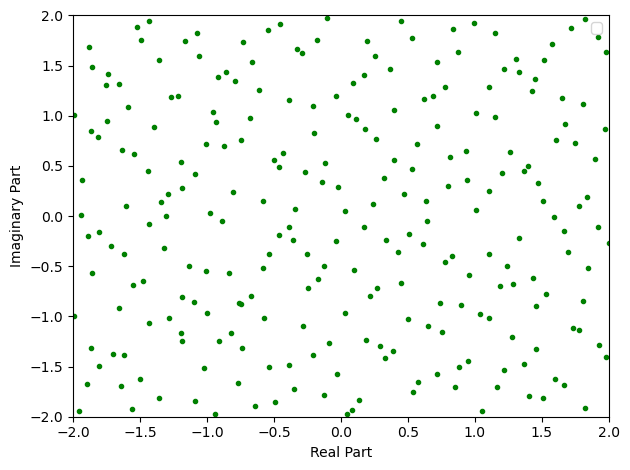

In [186]:
plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(1)
orthos = np.transpose(samplepoints_ss[0])
plt.plot(orthos[0],orthos[1], ccolors[4],linewidth=0.001)
plt.ylim(-2,2)
plt.xlim(-2,2)
#plt.title("Samples taken in the 1st Cycle", y=-0.2)
plt.ylabel("Imaginary Part")
plt.xlabel("Real Part")
plt.legend()
plt.tight_layout()
fig.savefig('samples_cycle_1_noTitle.png', dpi=300)
plt.show()

#### Samples in the second iteration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x500 with 0 Axes>

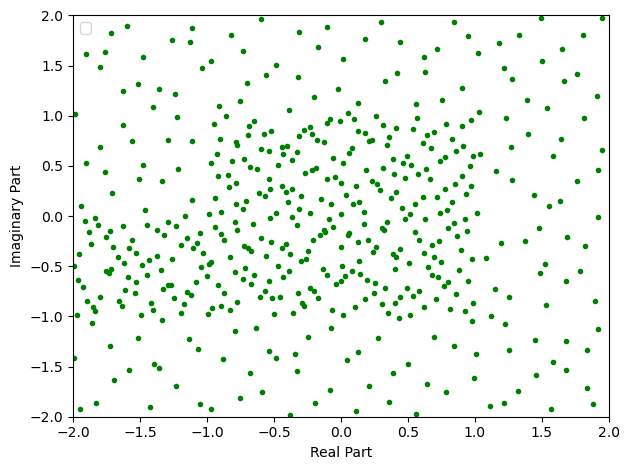

In [187]:
plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(1)
orthos = np.transpose(samplepoints_ss[1])
plt.plot(orthos[0],orthos[1], ccolors[4],linewidth=0.001)
plt.ylim(-2,2)
plt.xlim(-2,2)
#plt.title("Samples taken in the 2nd Cycle", y=-0.2)
plt.ylabel("Imaginary Part")
plt.xlabel("Real Part")
plt.legend()
plt.tight_layout()
fig.savefig('samples_cycle_2_noTitle.png', dpi=300)
plt.show()

#### Samples in the third iteration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x500 with 0 Axes>

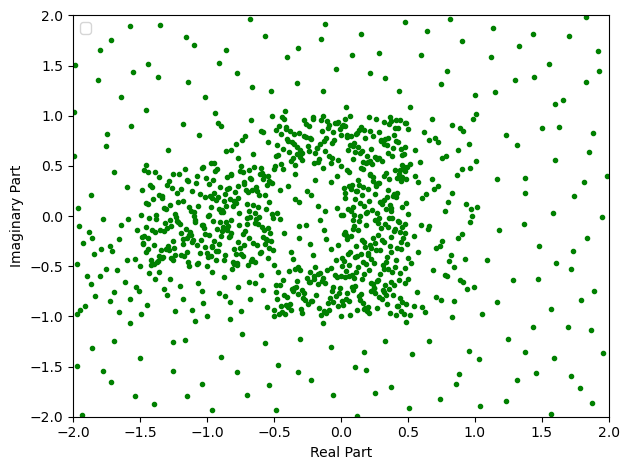

In [188]:
plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(1)
orthos = np.transpose(samplepoints_ss[2])
plt.plot(orthos[0],orthos[1], ccolors[4],linewidth=0.001)
plt.ylim(-2,2)
plt.xlim(-2,2)
#plt.title("Samples taken in the 3rd Cycle", y=-0.2)
plt.ylabel("Imaginary Part")
plt.xlabel("Real Part")
plt.legend()
plt.tight_layout()
fig.savefig('samples_cycle_3_noTitle.png', dpi=300)
plt.show()

#### Samples in the fourth iteration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x500 with 0 Axes>

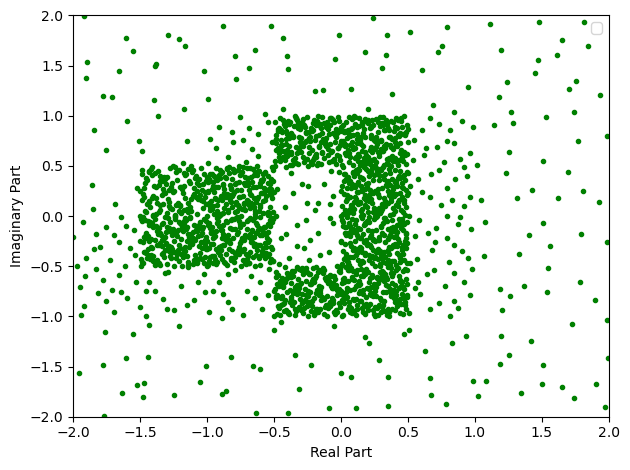

In [189]:
plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(1)
orthos = np.transpose(samplepoints_ss[3])
plt.plot(orthos[0],orthos[1], ccolors[4],linewidth=0.001)
plt.ylim(-2,2)
plt.xlim(-2,2)
#plt.title("Samples taken in the 4th Cycle", y=-0.2)
plt.ylabel("Imaginary Part")
plt.xlabel("Real Part")
plt.legend()
plt.tight_layout()
fig.savefig('samples_cycle_4_noTitle.png', dpi=300)
plt.show()

#### Samples in the fifth iteration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x500 with 0 Axes>

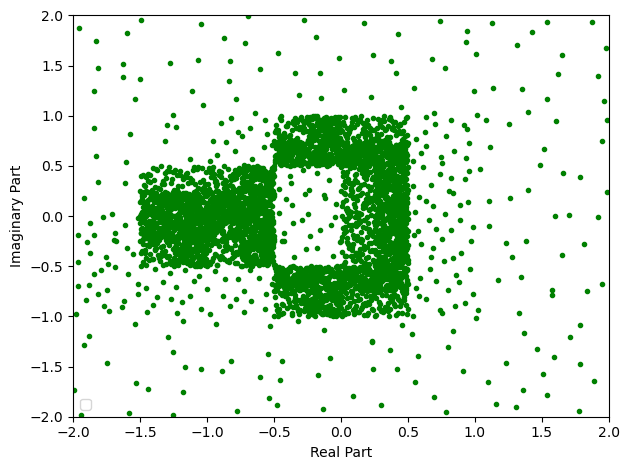

In [190]:
plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(1)
orthos = np.transpose(samplepoints_ss[4])
plt.plot(orthos[0],orthos[1], ccolors[4],linewidth=0.001)
plt.ylim(-2,2)
plt.xlim(-2,2)
#plt.title("Samples taken in the 5th Cycle", y=-0.2)
plt.ylabel("Imaginary Part")
plt.xlabel("Real Part")
plt.legend()
plt.tight_layout()
fig.savefig('samples_cycle_5_noTitle.png', dpi=300)
plt.show()

#### Samples in the sixth iteration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x500 with 0 Axes>

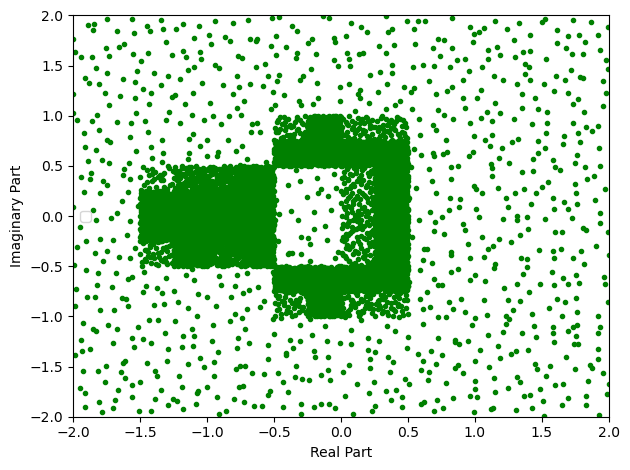

In [191]:
plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(1)
orthos = np.transpose(samplepoints_ss[5])
plt.plot(orthos[0],orthos[1], ccolors[4],linewidth=0.001)
plt.ylim(-2,2)
plt.xlim(-2,2)
#plt.title("Samples taken in the 6th Cycle", y=-0.2)
plt.ylabel("Imaginary Part")
plt.xlabel("Real Part")
plt.legend()
plt.tight_layout()
fig.savefig('samples_cycle_6_noTitle.png', dpi=300)
plt.show()